In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [24]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'

In [41]:
def load_data(training_batch_size, testing_batch_size):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(
        root='data', 
        train=True, 
        download=True, 
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=training_batch_size, 
        shuffle=True
    )
    test_dataset = datasets.MNIST(
        root='data', 
        train=False, 
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=testing_batch_size, 
        shuffle=True
    )
    return (train_loader, test_loader)


In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Fully connected (dense) layers
        self.dense_layer1 = nn.Linear(16 * 5 * 5, 120)
        self.dense_layer2 = nn.Linear(120, 84)
        self.dense_layer3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.avg_pool2d(F.selu(self.conv1(x)), kernel_size=2)
        x = F.avg_pool2d(F.selu(self.conv2(x)), kernel_size=2)
        x = torch.flatten(x, start_dim=1)
        x = F.selu(self.dense_layer1(x))
        x = F.selu(self.dense_layer2(x))
        x = self.dense_layer3(x)
        
        return x


In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)

        # Define fully connected (dense) layers
        self.dense_layer1 = nn.Linear(1024, 256)
        self.dense_layer2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(F.avg_pool2d(self.conv2(x), kernel_size=2))
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.elu(F.max_pool2d(self.conv3(x), kernel_size=2))
        x = F.dropout(x, p=0.4, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = F.elu(self.dense_layer1(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.dense_layer2(x)
        return F.log_softmax(x, dim=1)


In [44]:
training_batch_size = 64
testing_batch_size = 1000
train_loader, test_loader = load_data(training_batch_size, testing_batch_size)

In [45]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    train_loss = 0
    n_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.item()))
            print("Train Accuracy: {:.2f}%".format(acc))
    train_loss /= len(train_loader)

    return train_loss, round(acc, 2)


In [30]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)

        output = model(data)
        test_loss += loss_fn(output, target).data

        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [37]:
torch.manual_seed(1)
model = LeNet()
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
m0_loss_arr = []
m0_acc_arr = []
epochs = 10
log_interval = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader, log_interval)
    m0_loss_arr.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)
    scheduler.step()
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.2f}%")


Train Epoch: 1 [0/60000]	Loss: 2.284896
Train Accuracy: 6.25%
Train Epoch: 1 [6400/60000]	Loss: 0.534195
Train Accuracy: 66.62%
Train Epoch: 1 [12800/60000]	Loss: 0.254355
Train Accuracy: 76.17%
Train Epoch: 1 [19200/60000]	Loss: 0.267097
Train Accuracy: 80.20%
Train Epoch: 1 [25600/60000]	Loss: 0.346166
Train Accuracy: 82.58%
Train Epoch: 1 [32000/60000]	Loss: 0.184206
Train Accuracy: 84.26%
Train Epoch: 1 [38400/60000]	Loss: 0.329525
Train Accuracy: 85.67%
Train Epoch: 1 [44800/60000]	Loss: 0.220180
Train Accuracy: 86.73%
Train Epoch: 1 [51200/60000]	Loss: 0.331092
Train Accuracy: 87.57%
Train Epoch: 1 [57600/60000]	Loss: 0.321759
Train Accuracy: 88.32%

Test set, Epoch 1 , Average loss: 0.1627, Accuracy: 9510/10000 (95%)

Epoch 1: Loss = 0.3943, Accuracy = 88.55%
Train Epoch: 2 [0/60000]	Loss: 0.195211
Train Accuracy: 95.31%
Train Epoch: 2 [6400/60000]	Loss: 0.122334
Train Accuracy: 94.96%
Train Epoch: 2 [12800/60000]	Loss: 0.174159
Train Accuracy: 94.85%
Train Epoch: 2 [19200/60000

In [38]:
torch.manual_seed(1)
model_1= CNN()
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum)
m1_loss_arr = []
m1_acc_arr = []

epochs = 10
log_interval = 100
for epoch in range(1, epochs + 1):
    loss, acc = train(model_1, optimizer, epoch, train_loader, log_interval=log_interval)
    m1_loss_arr.append(loss)
    m1_acc_arr.append(acc)
    test(model_1, epoch, test_loader)

Train Epoch: 1 [0/60000]	Loss: 2.289357
Train Accuracy: 10.94%
Train Epoch: 1 [6400/60000]	Loss: 0.625862
Train Accuracy: 58.08%
Train Epoch: 1 [12800/60000]	Loss: 0.636466
Train Accuracy: 71.12%
Train Epoch: 1 [19200/60000]	Loss: 0.206638
Train Accuracy: 77.07%
Train Epoch: 1 [25600/60000]	Loss: 0.240876
Train Accuracy: 80.63%
Train Epoch: 1 [32000/60000]	Loss: 0.178774
Train Accuracy: 82.68%
Train Epoch: 1 [38400/60000]	Loss: 0.380755
Train Accuracy: 84.39%
Train Epoch: 1 [44800/60000]	Loss: 0.394669
Train Accuracy: 85.73%
Train Epoch: 1 [51200/60000]	Loss: 0.249896
Train Accuracy: 86.75%
Train Epoch: 1 [57600/60000]	Loss: 0.324279
Train Accuracy: 87.57%

Test set, Epoch 1 , Average loss: 0.0997, Accuracy: 9678/10000 (97%)

Train Epoch: 2 [0/60000]	Loss: 0.157350
Train Accuracy: 93.75%
Train Epoch: 2 [6400/60000]	Loss: 0.136194
Train Accuracy: 95.20%
Train Epoch: 2 [12800/60000]	Loss: 0.092628
Train Accuracy: 95.10%
Train Epoch: 2 [19200/60000]	Loss: 0.061094
Train Accuracy: 95.26%
T

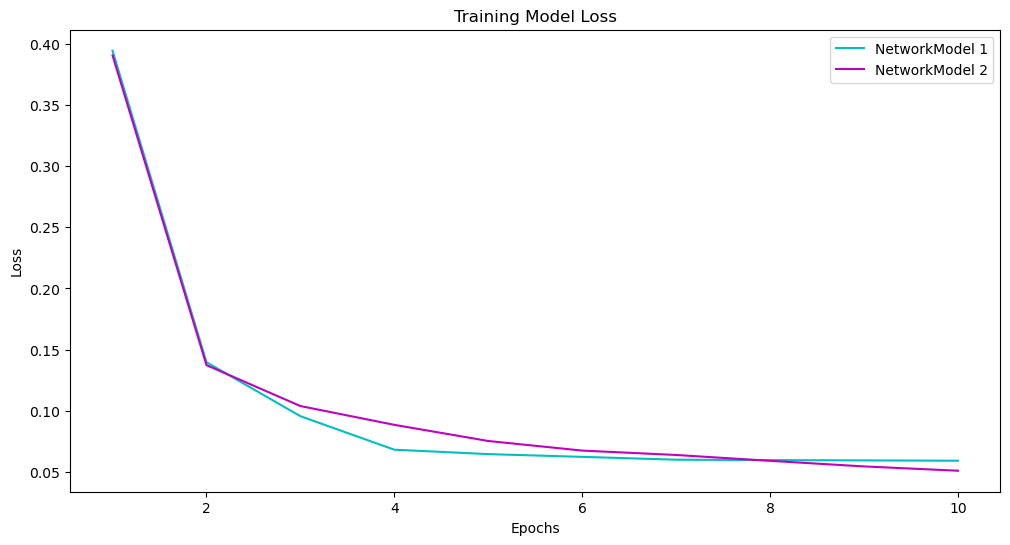

In [39]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_loss_arr, color = "c")
plt.plot(np.arange(1, 11, 1), m1_loss_arr, color = "m")
plt.title('Training Model Loss')
plt.legend(['NetworkModel 1', 'NetworkModel 2'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


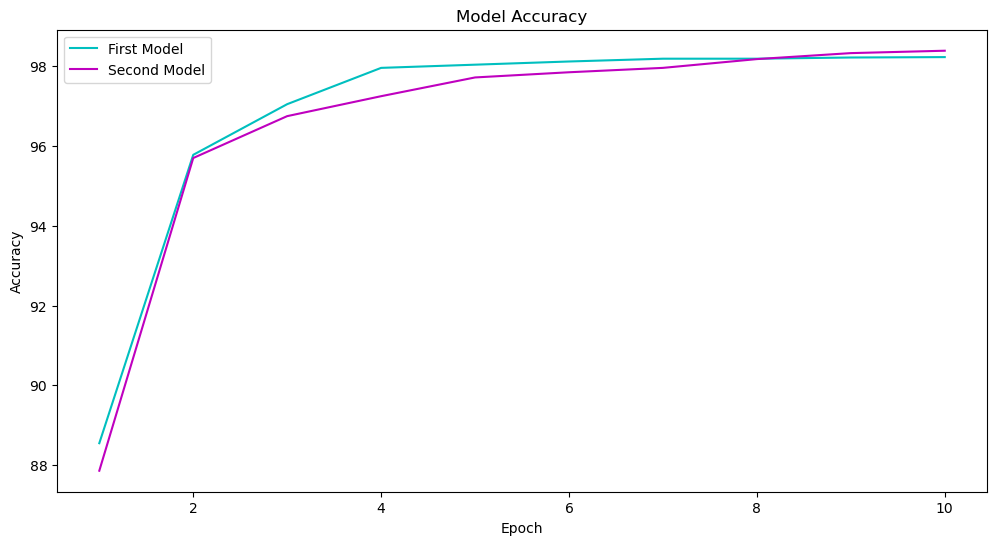

In [40]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_acc_arr, color = "c")
plt.plot(np.arange(1, 11, 1), m1_acc_arr, color = "m")
plt.title('Model Accuracy')
plt.legend(['First Model', 'Second Model'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()